In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from python.dataset.data_reader import read_dataset
from python.dlf.dlf import DLF
from python.util import BATCH_SIZE, ModelMode

In [2]:
dataset = read_dataset('../data', '2997', is_train=False)

data size  26944 

data size  129119 



In [3]:
def get_probabilities(h, bid_range):
    distribution = []
    S = []
    W = []

    prefix = 1
    for i in bid_range:
        prob = (1 - h[i]) * prefix
        distribution.append(prob)

        prefix = prefix * h[i]
        S.append(prefix)
        W.append(1 - prefix)

    return {'Distribution': distribution, 'Lossing': S, 'Winning': W}

In [4]:
def draw_plot(probability_dict, bid_range, z):
    fig, ax = plt.subplots(len(probability_dict))
    fig.set_figheight(4)
    fig.set_figwidth(5)

    i = 0
    for name, values in probability_dict.items():
        ax[i].plot(bid_range, values, label='probability')
        ax[i].vlines(z, min(values), max(values), label='market price', color='red')
        ax[i].set_xlabel('bids')
        ax[i].set_ylabel(name)
        ax[i].legend()

        i += 1
    plt.show()

def draw_single_plot(probability_dicts, bid_range, z, b):
    fig, ax = plt.subplots(len(probability_dicts[0]), len(probability_dicts))
    fig.set_figheight(30)
    fig.set_figwidth(10)

    for j in range(len(probability_dicts)):
        model_name = 'dlf' if j == 0 else 'attention'
        i = 0
        for name, values in probability_dicts[j].items():
            ax[i][j].set_title('%s [z=%d, b=%d]' % (model_name, z, b))
            ax[i][j].plot(bid_range, values, label='probability')
            ax[i][j].vlines(z, min(values), max(values), label='market price', color='red')
            ax[i][j].set_xlabel('bids')
            ax[i][j].set_ylabel(name)
            ax[i][j].legend()

            i += 1
    plt.show()

In [5]:
def read_checkpoint(model_name):
    checkpoint_path = '../output/checkpoint/aws/' + model_name + '/cp-{epoch:02d}.ckpt'
    checkpoint_dir = os.path.dirname(checkpoint_path)
    return tf.train.latest_checkpoint(checkpoint_dir)

In [6]:
dlf = DLF(ModelMode.DLF)
dlf.build(input_shape=([BATCH_SIZE, 16], [BATCH_SIZE, 2]))

latest = read_checkpoint('dlf_2997_all__0.25_0.75_0.0001_20200502_1437')
dlf.load_weights(latest)

In [7]:
dlf_attention = DLF(ModelMode.DLF_ATTENTION)
dlf_attention.build(input_shape=([BATCH_SIZE, 16], [BATCH_SIZE, 2]))

latest = read_checkpoint('dlf_attention_2997_all__0.25_0.75_0.0001_20200502_1753')
dlf_attention.load_weights(latest)

In [8]:
def predict_and_draw(features, bids):
    dlf_h = dlf.predict_on_batch([features, bids]).numpy()
    dlf_attention_h = dlf_attention.predict_on_batch([features, bids]).numpy()

    bid_range = np.arange(0, 305)
    for i in range(0, len(bids), 10):
        z, b = bids[i]

        dlf_prob_dict = get_probabilities(dlf_h[i], bid_range)
        dlf_attention_prod_dict = get_probabilities(dlf_attention_h[i], bid_range)
        draw_single_plot([dlf_prob_dict, dlf_attention_prod_dict], bid_range, z, b)

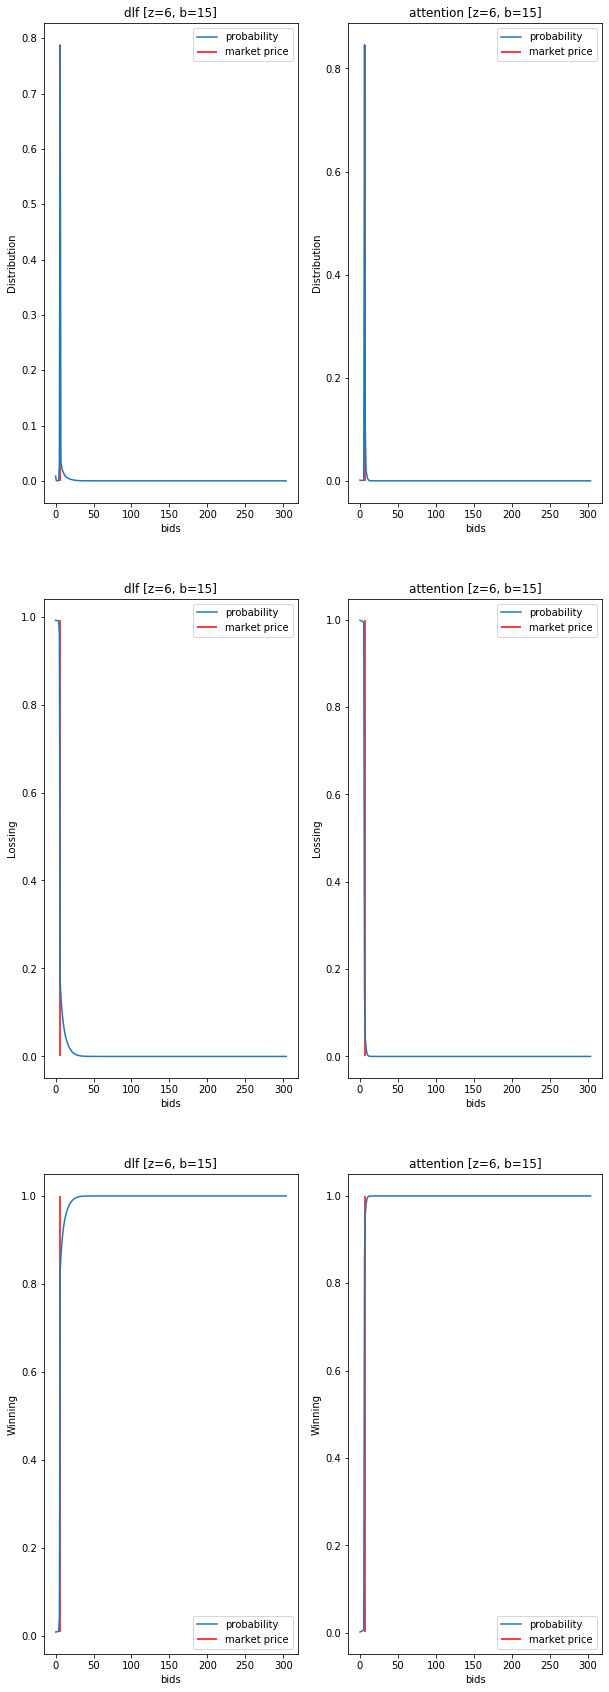

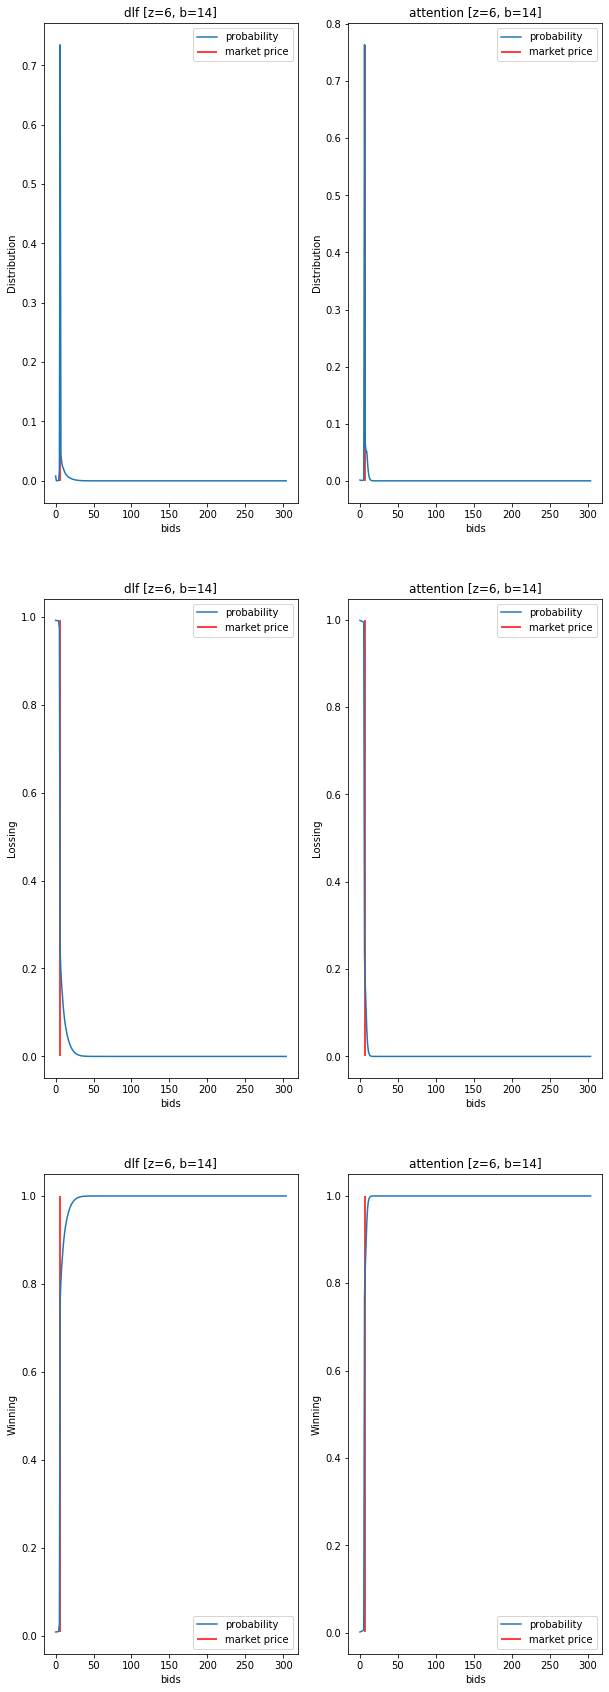

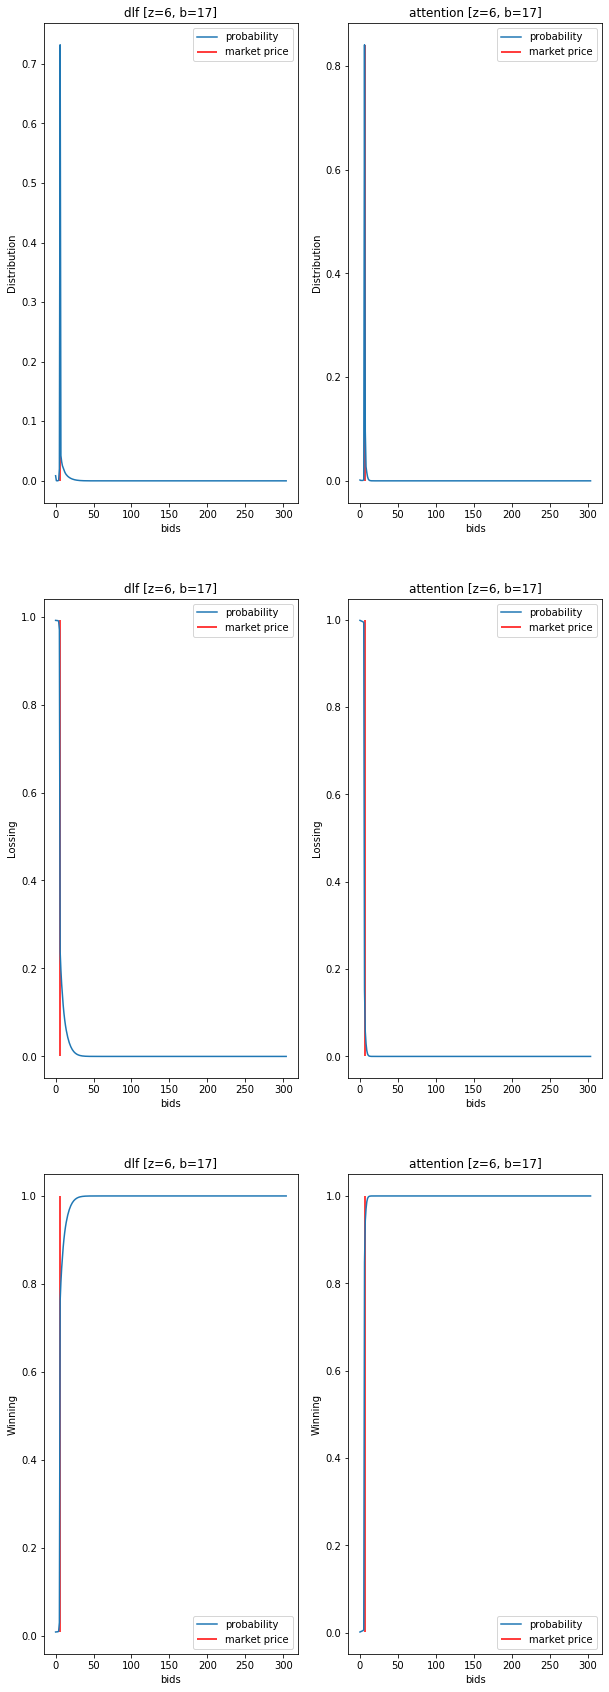

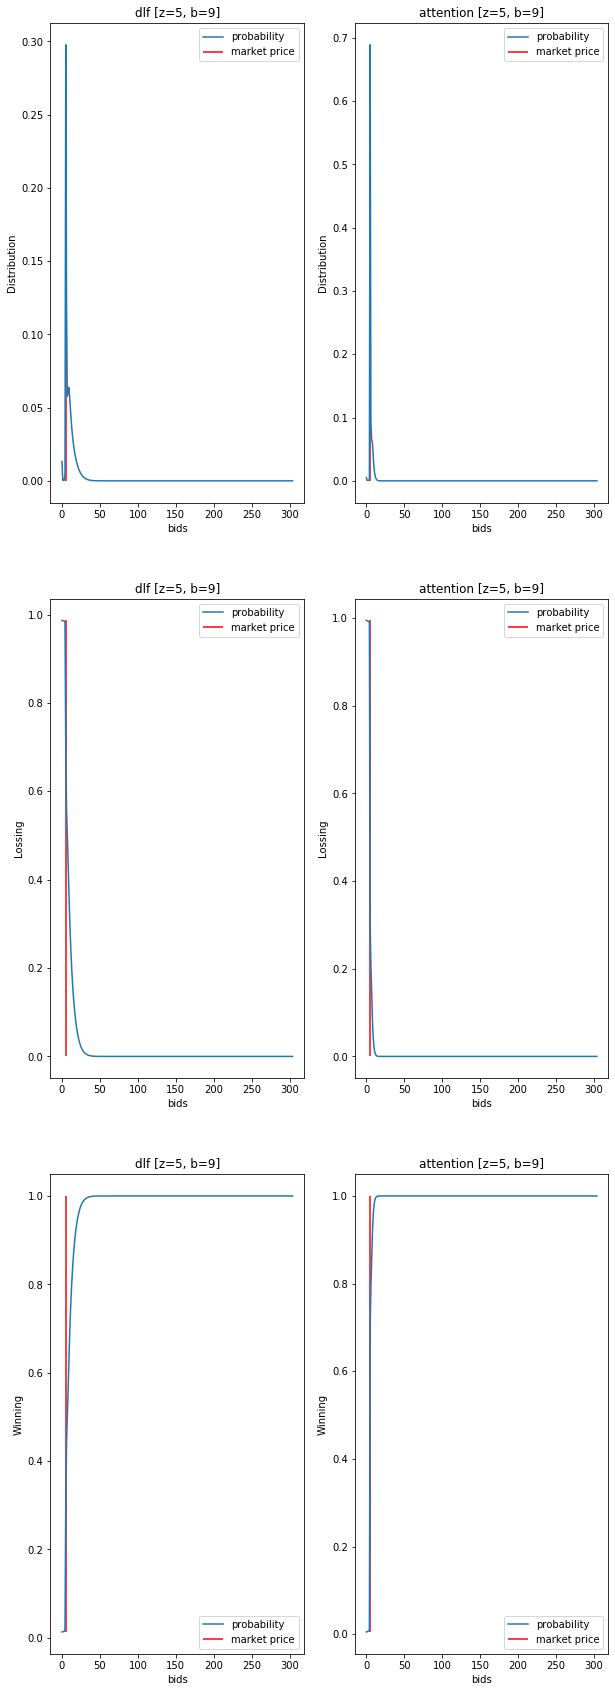

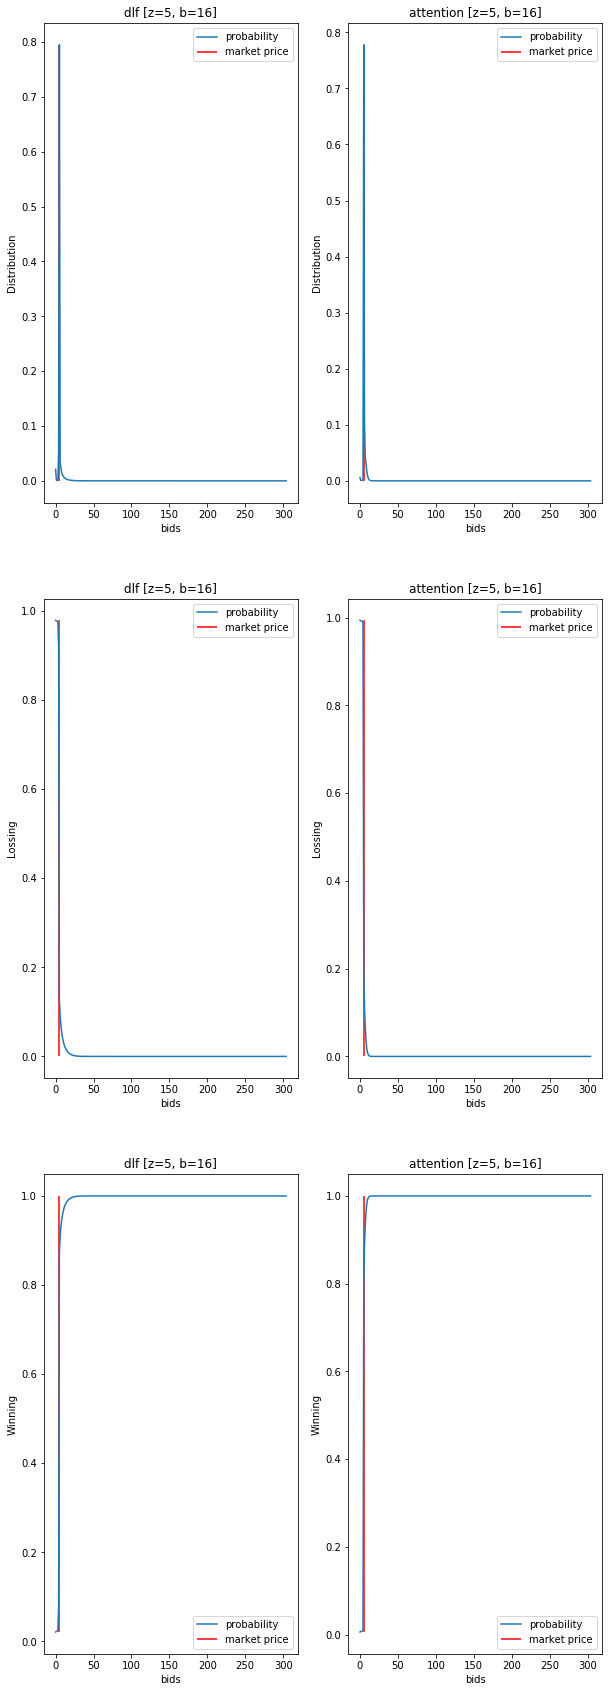

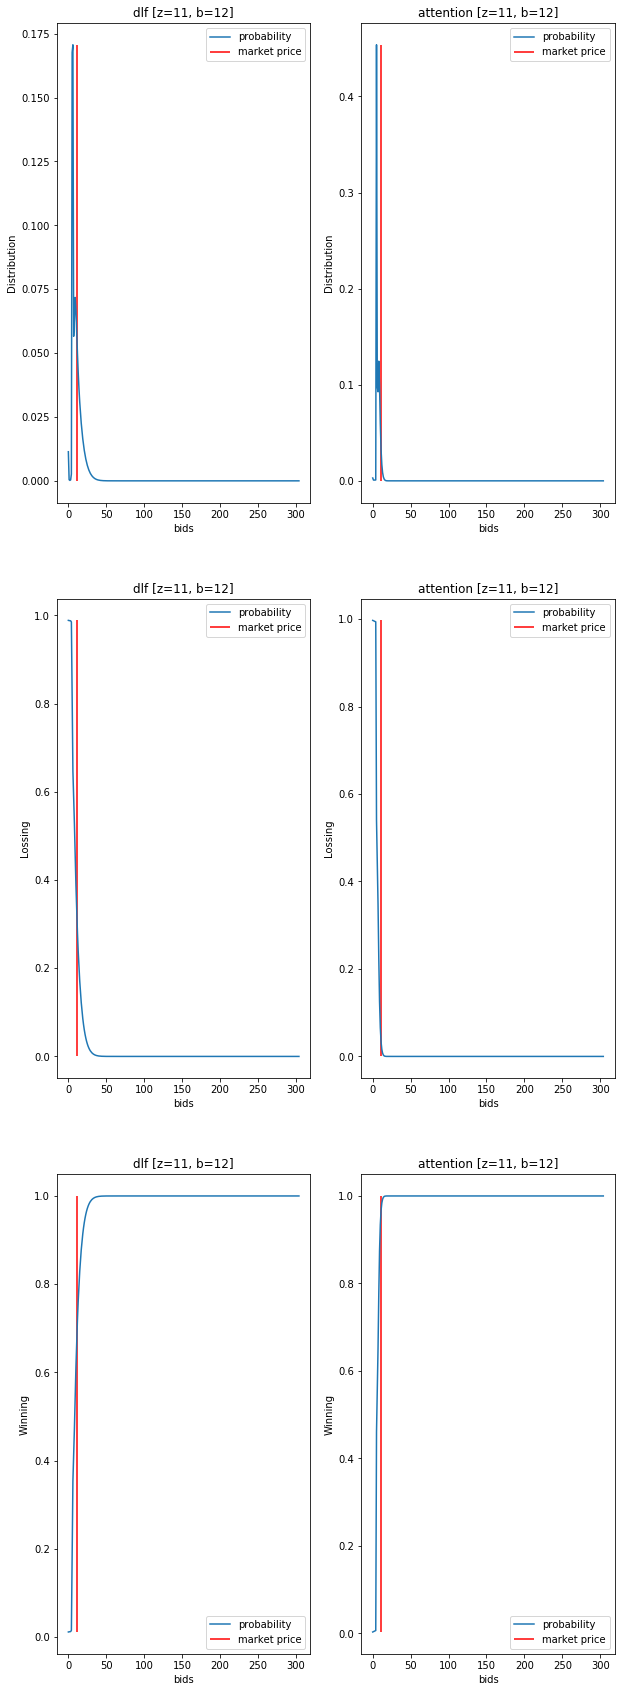

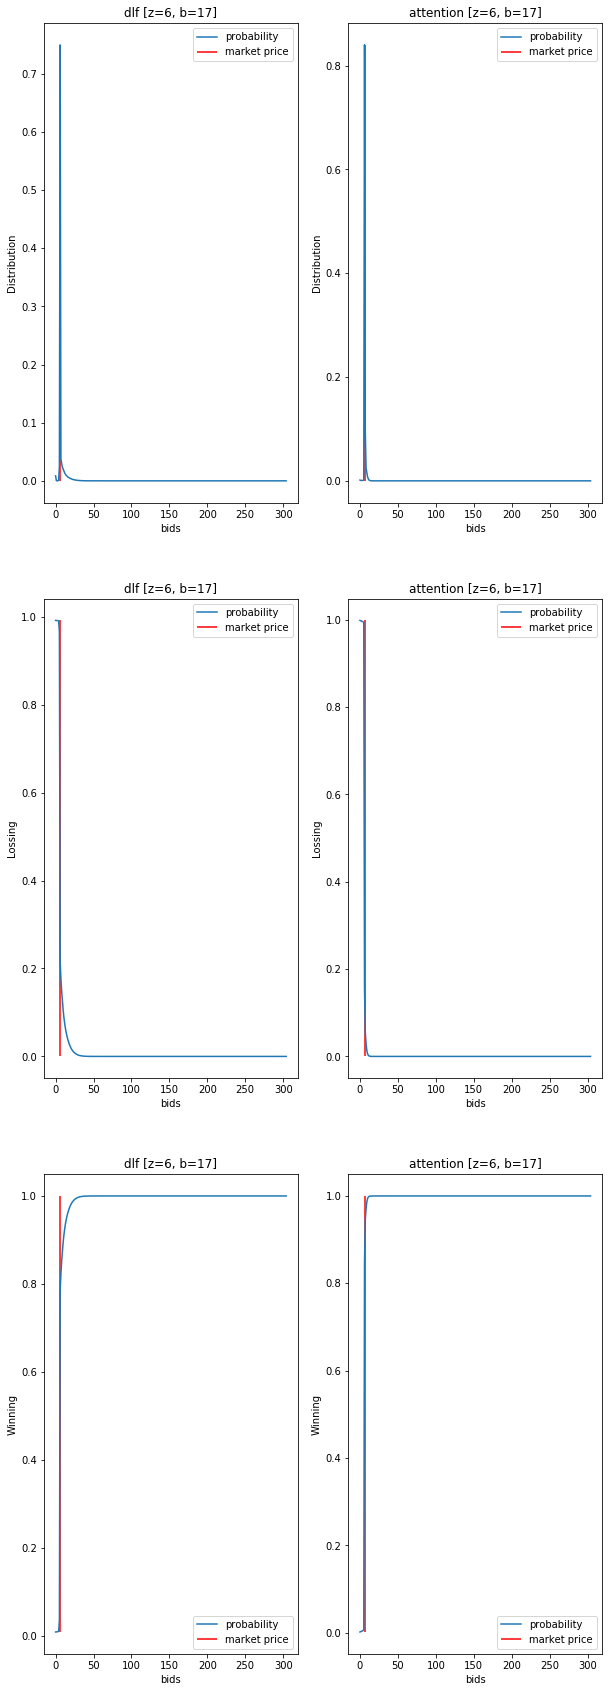

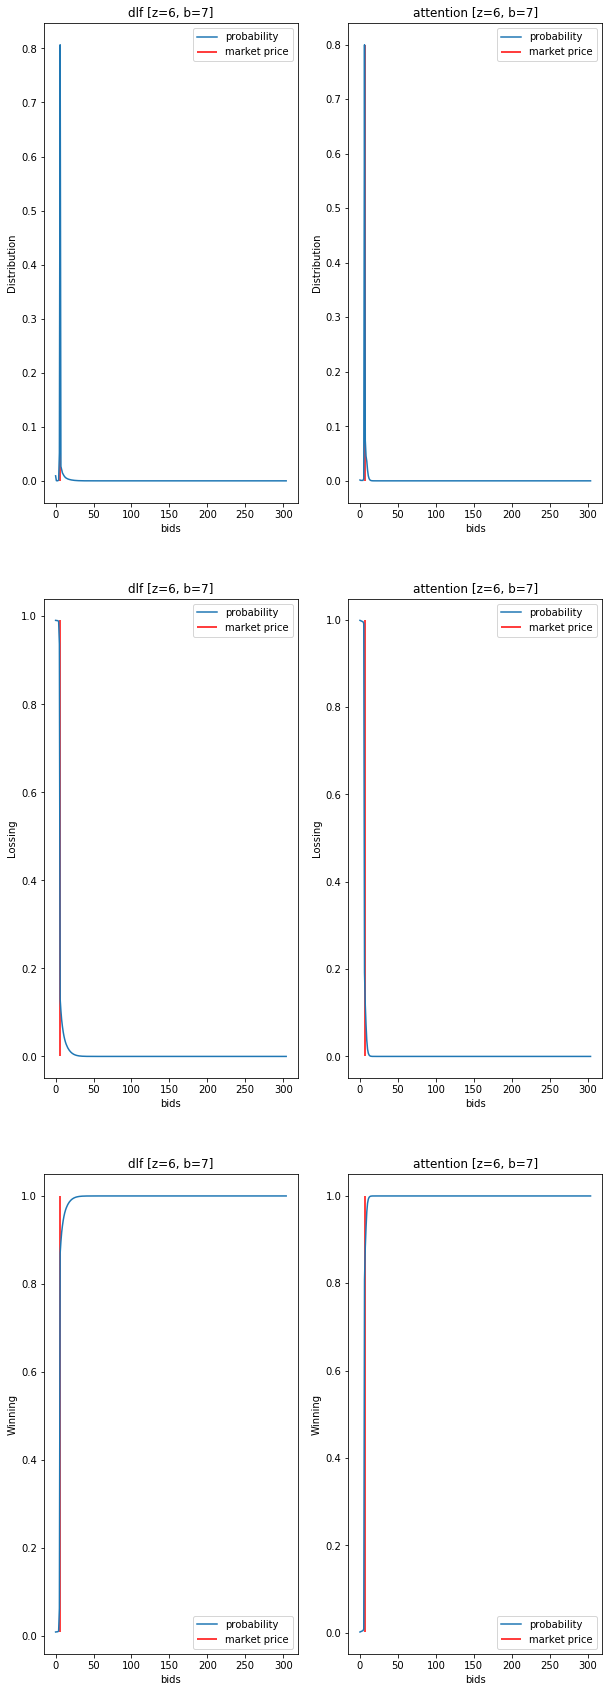

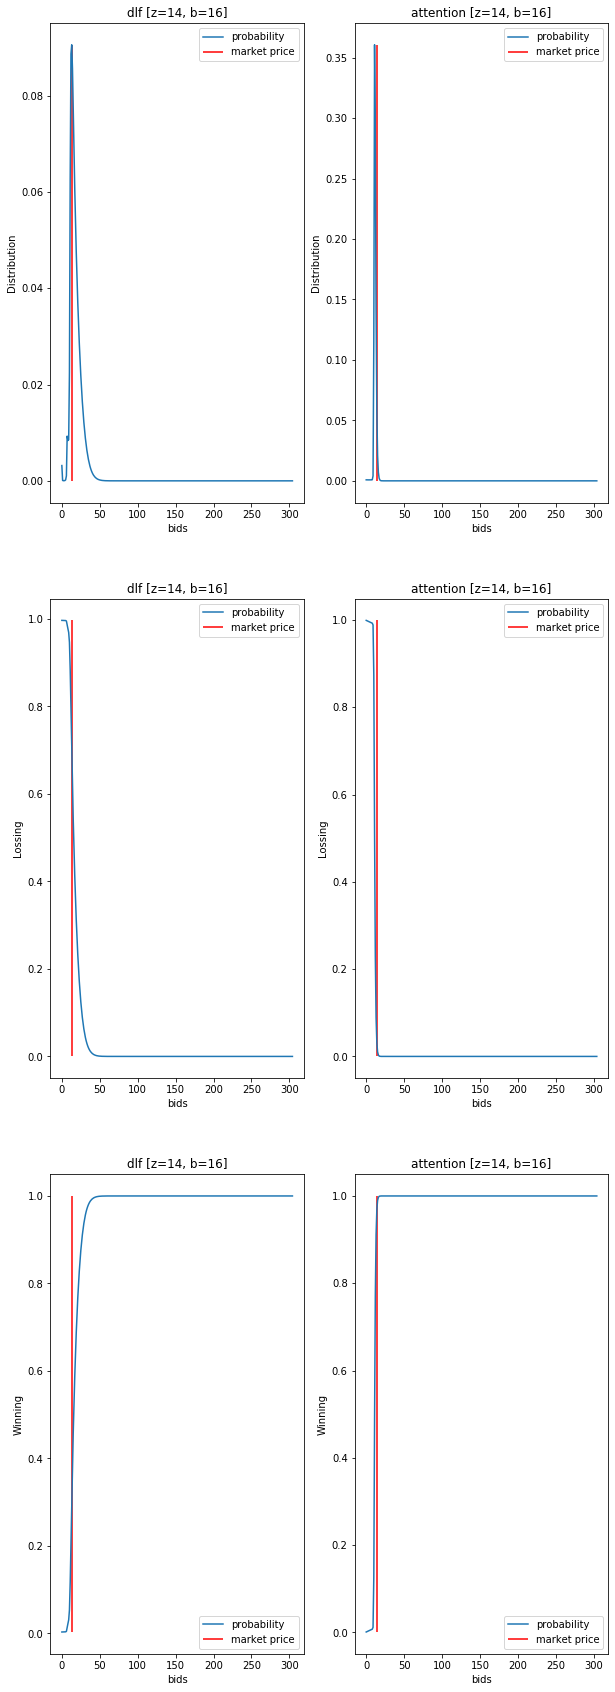

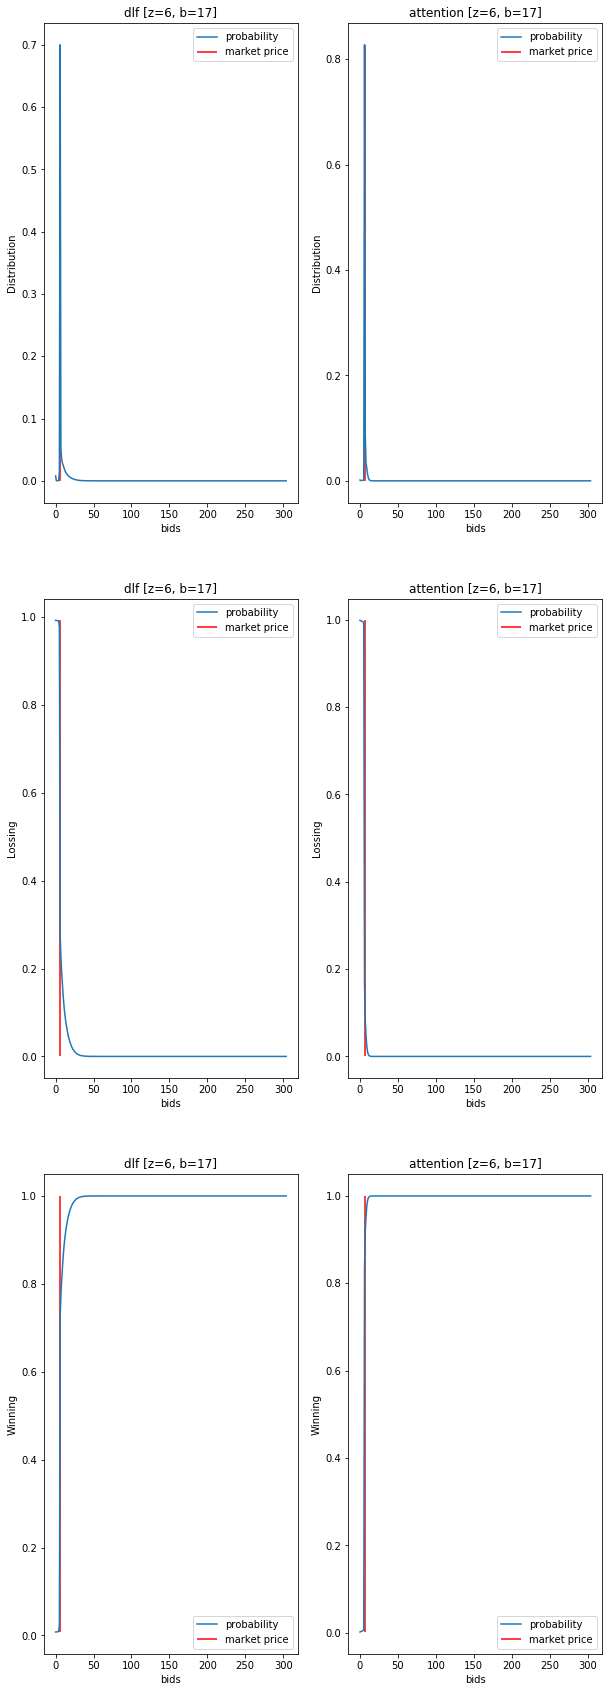

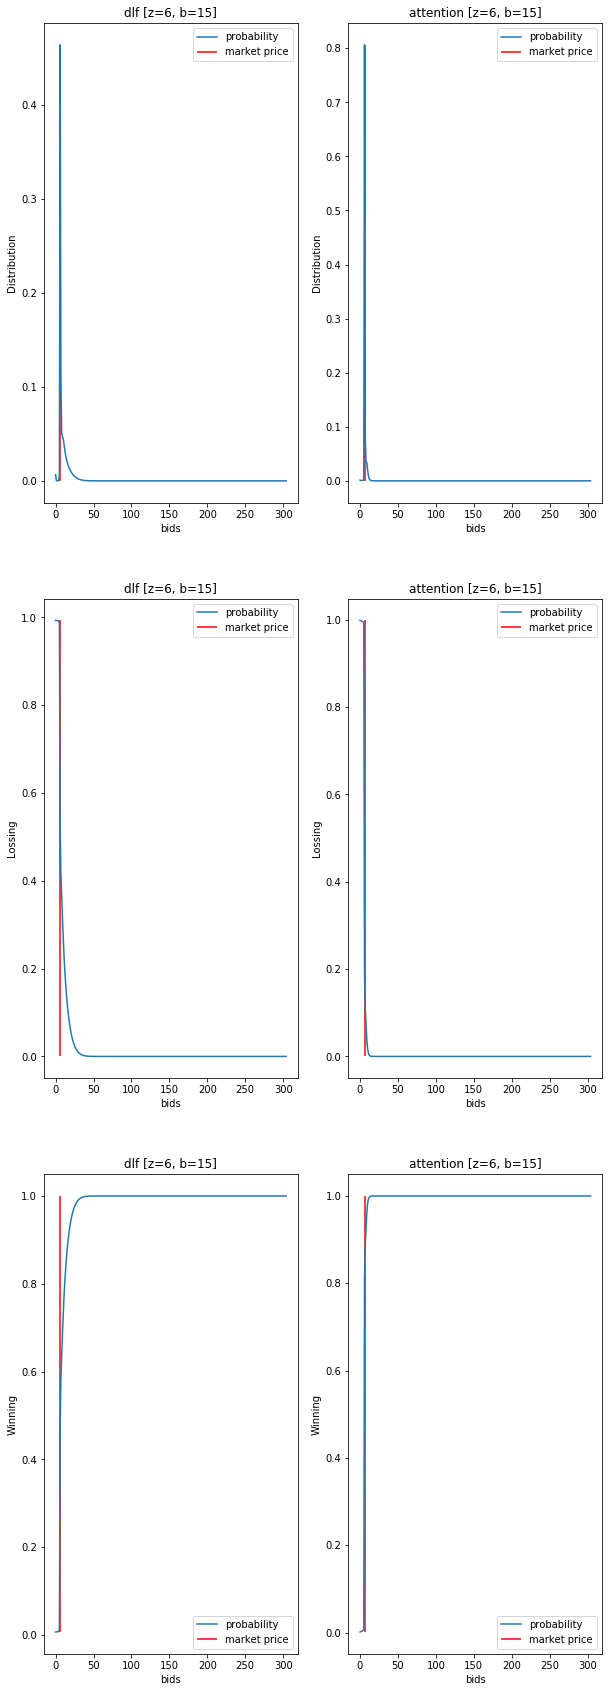

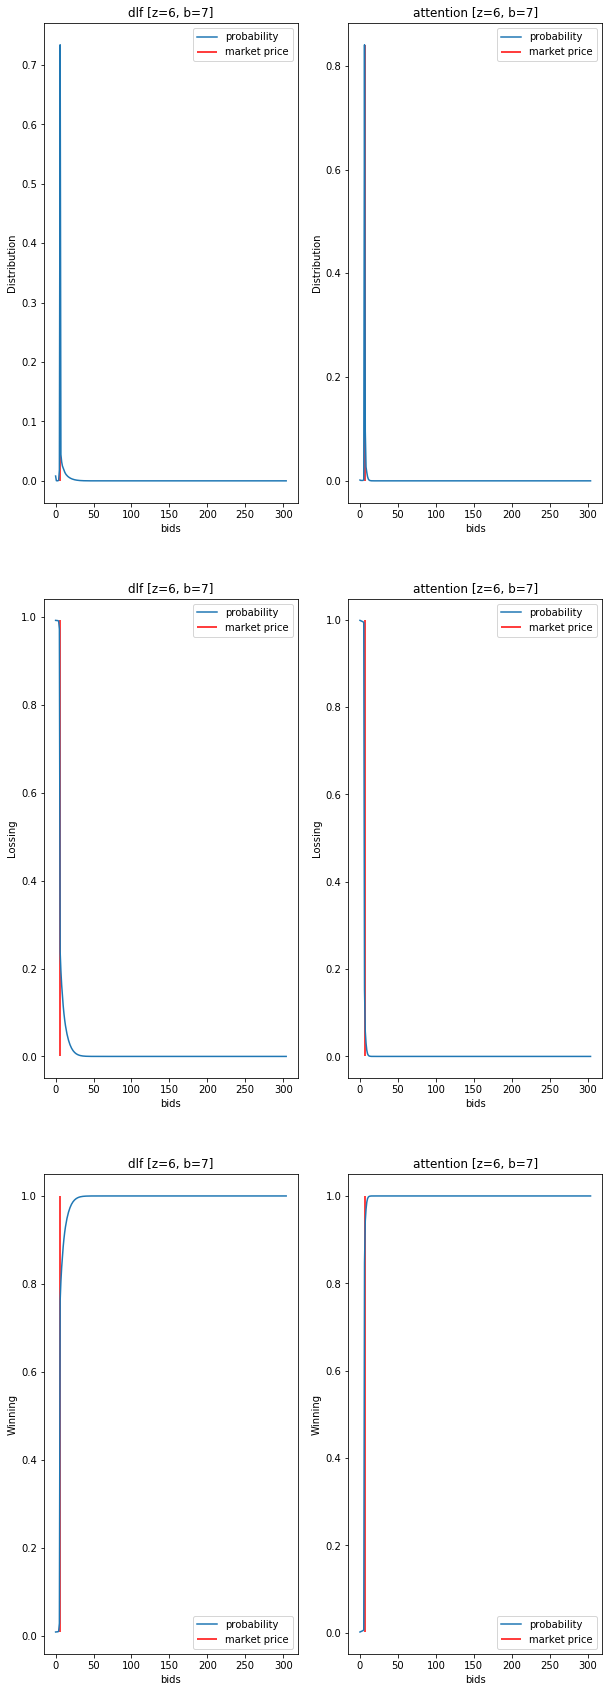

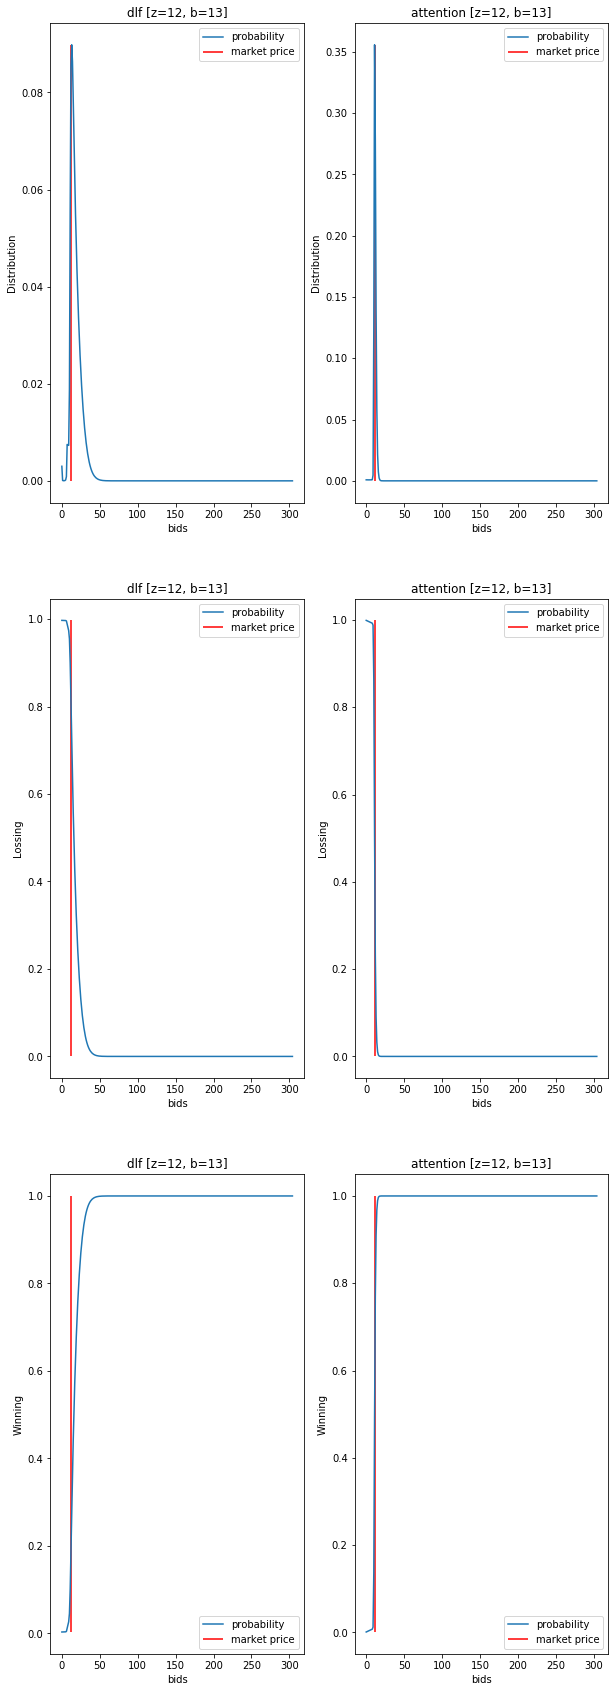

In [9]:
# Winning cases
features, bids, _ = dataset.next_win()
predict_and_draw(features, bids)

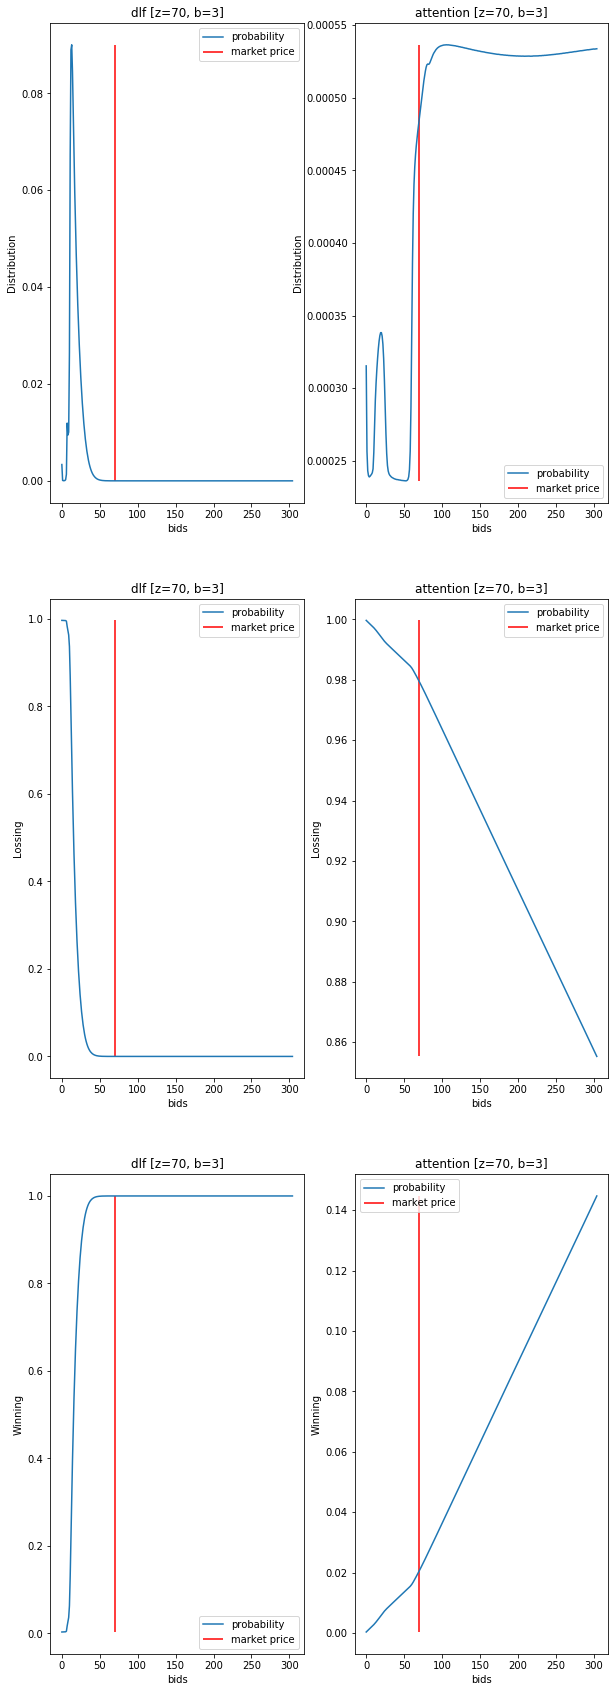

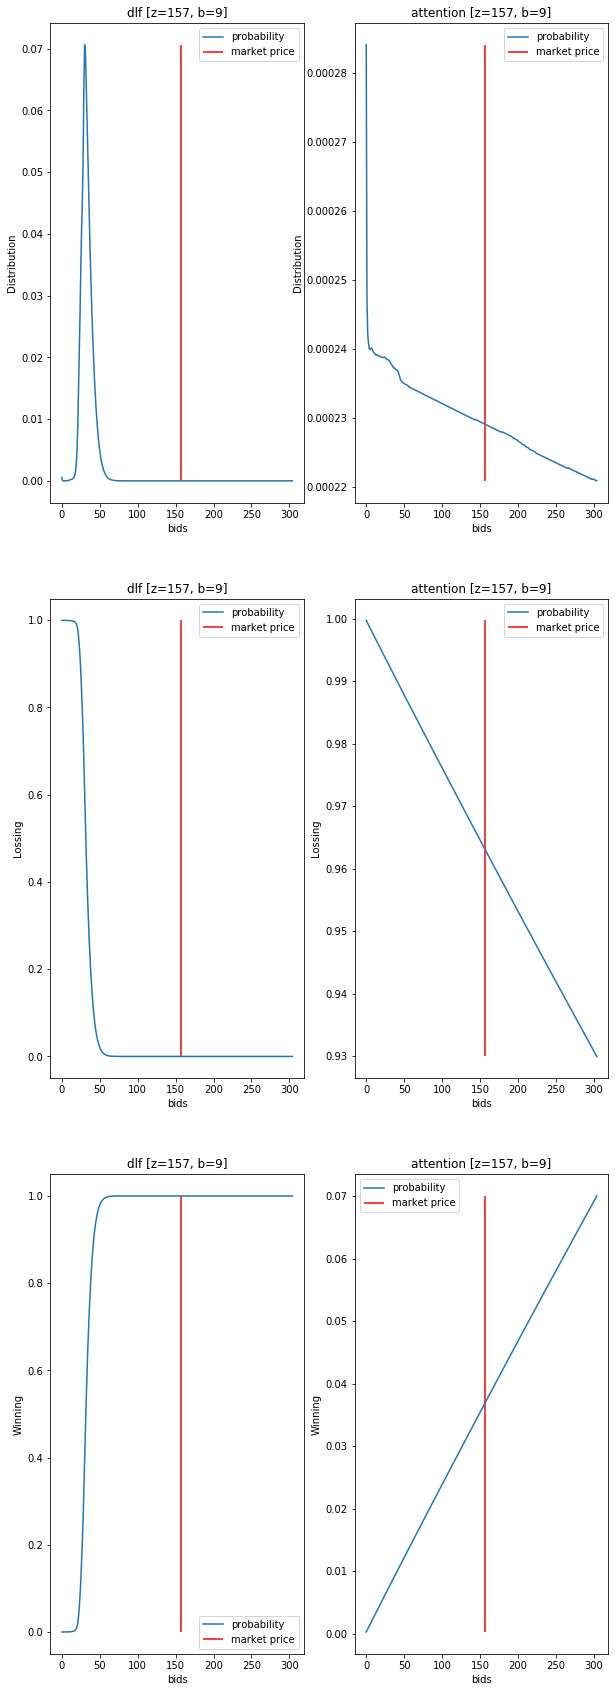

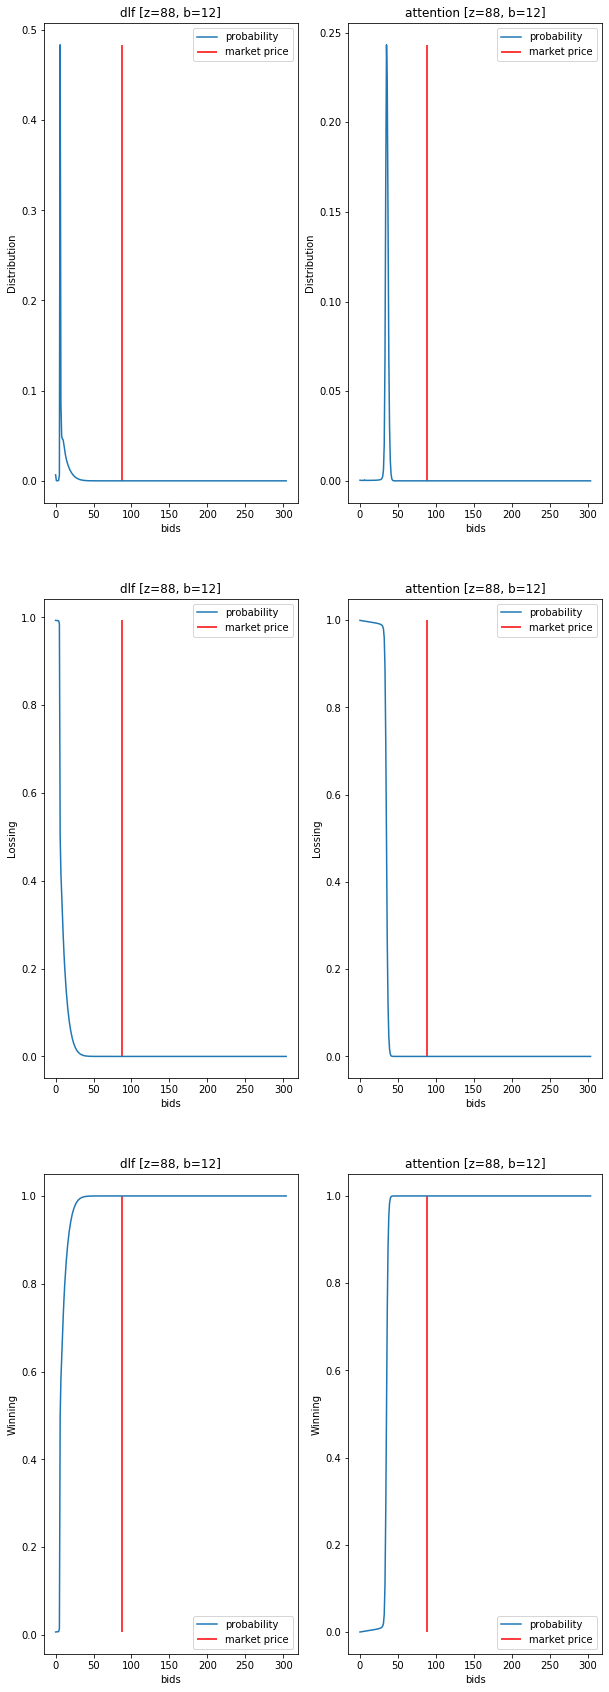

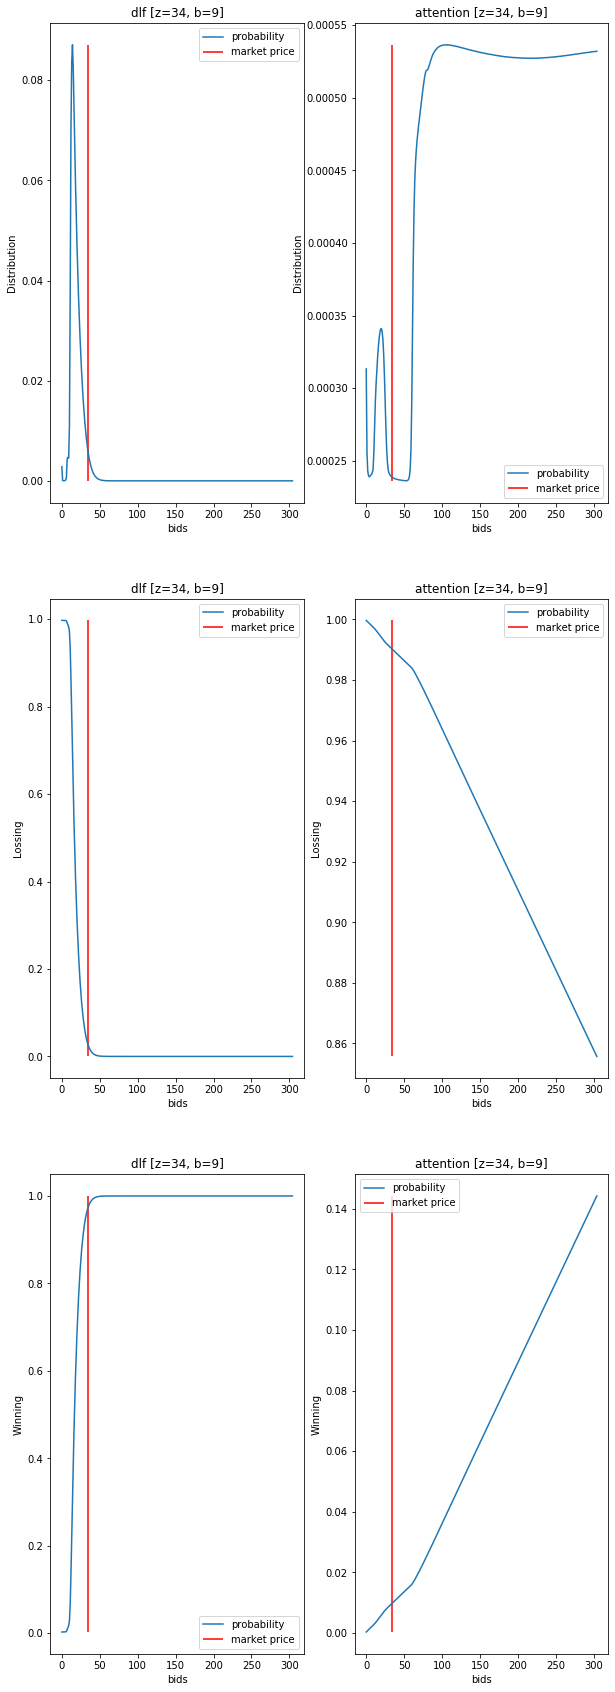

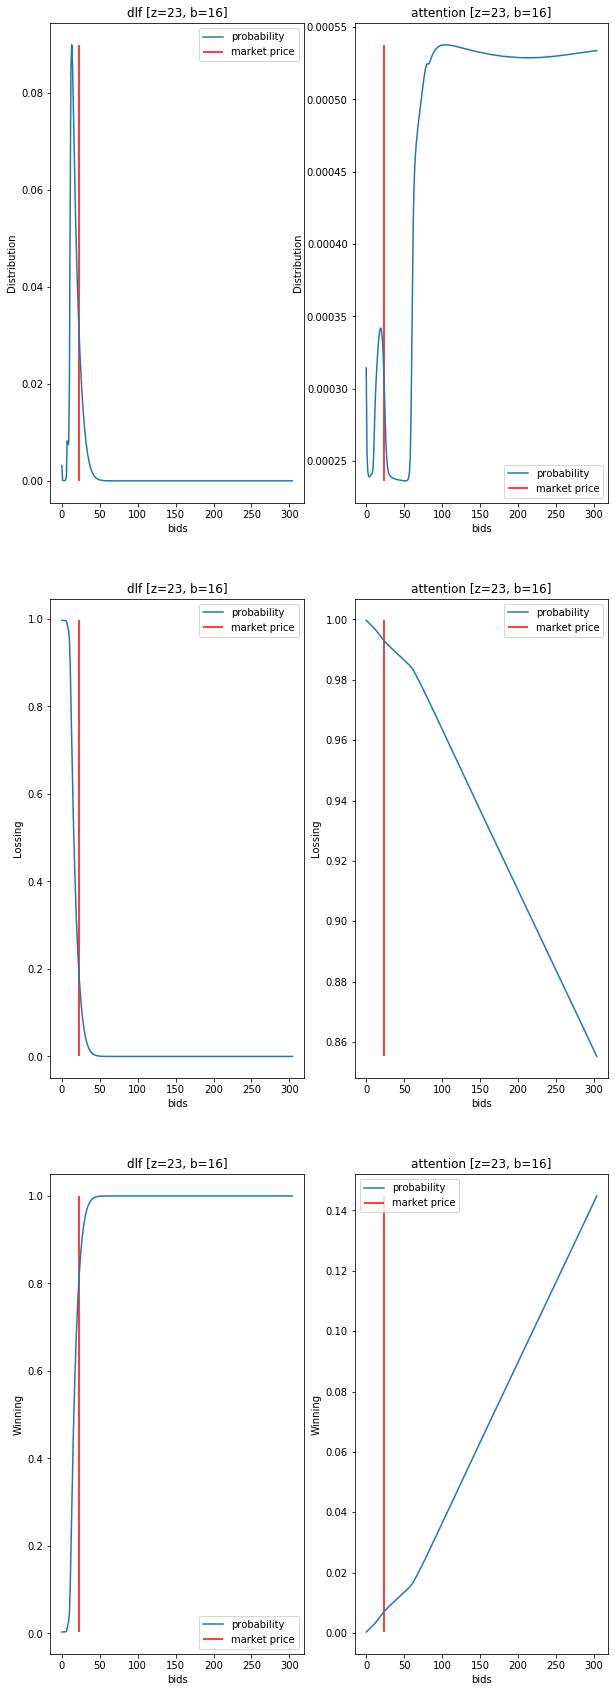

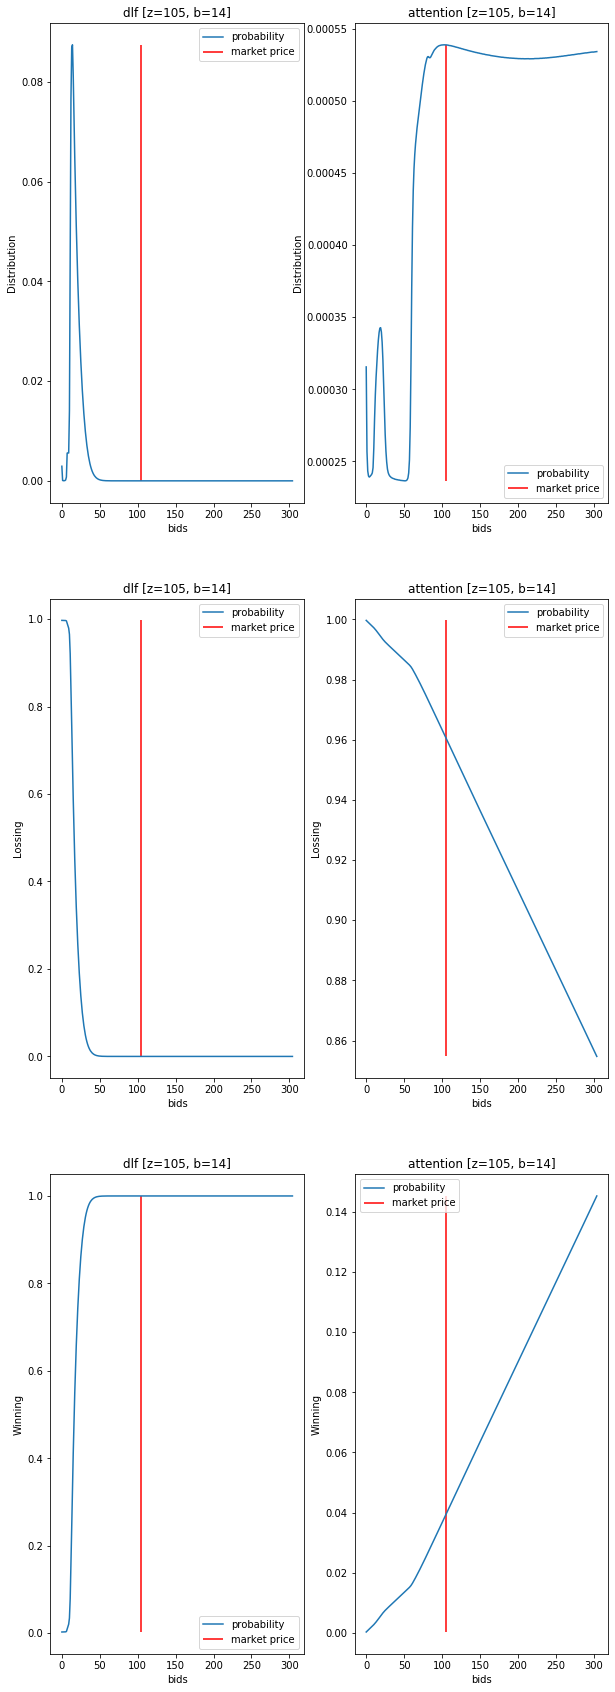

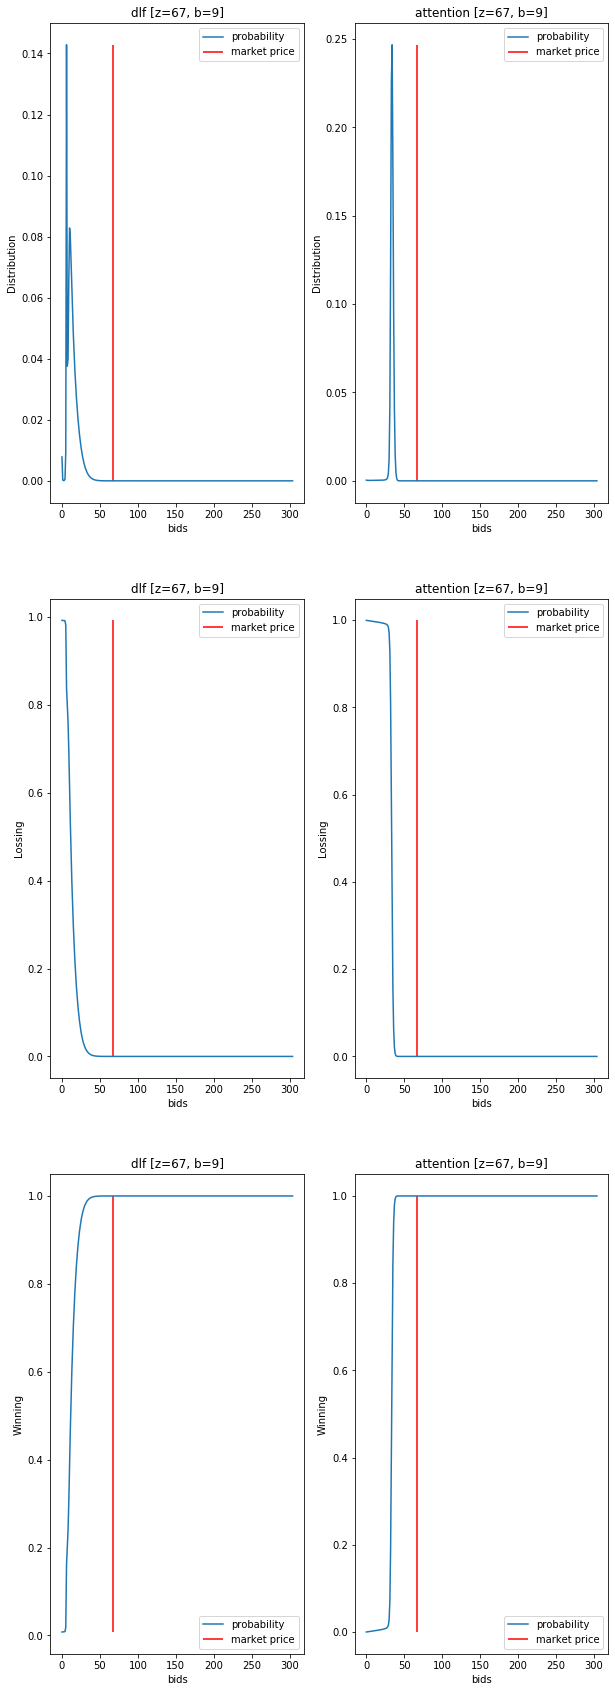

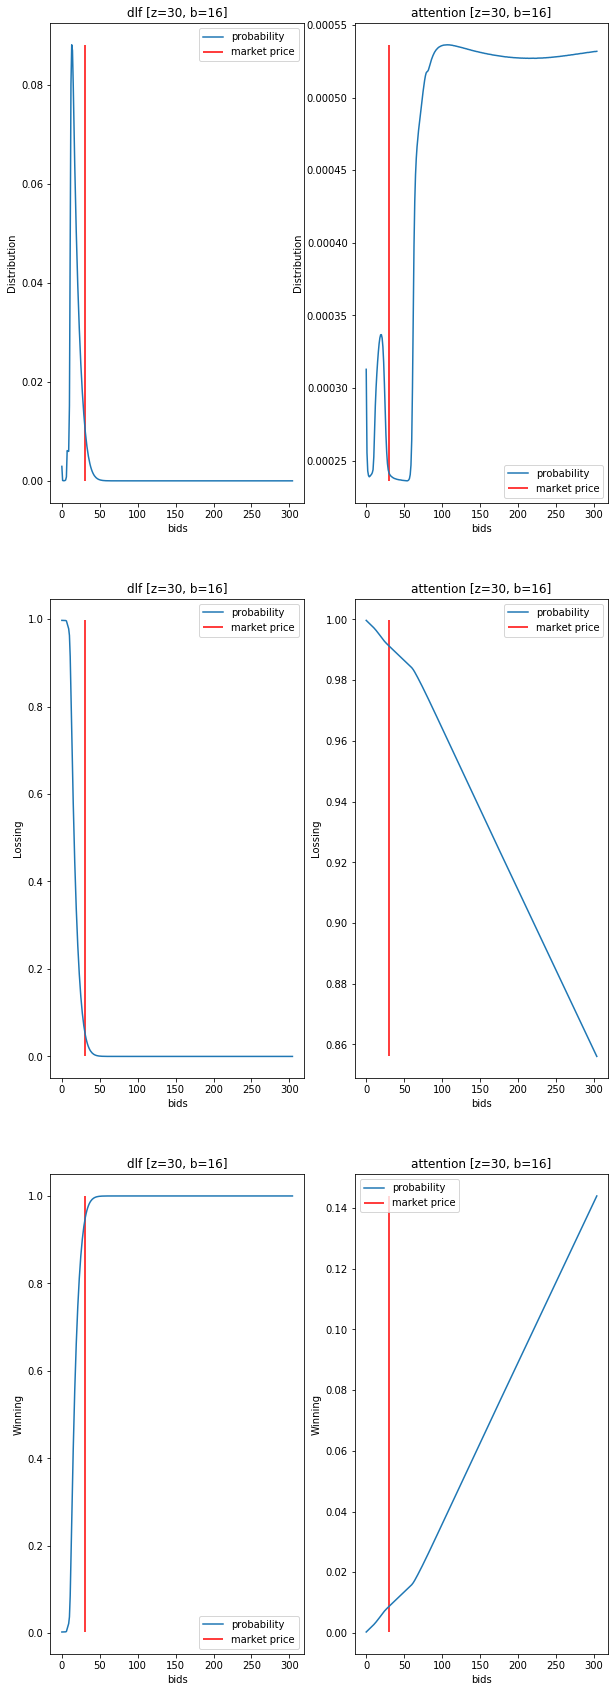

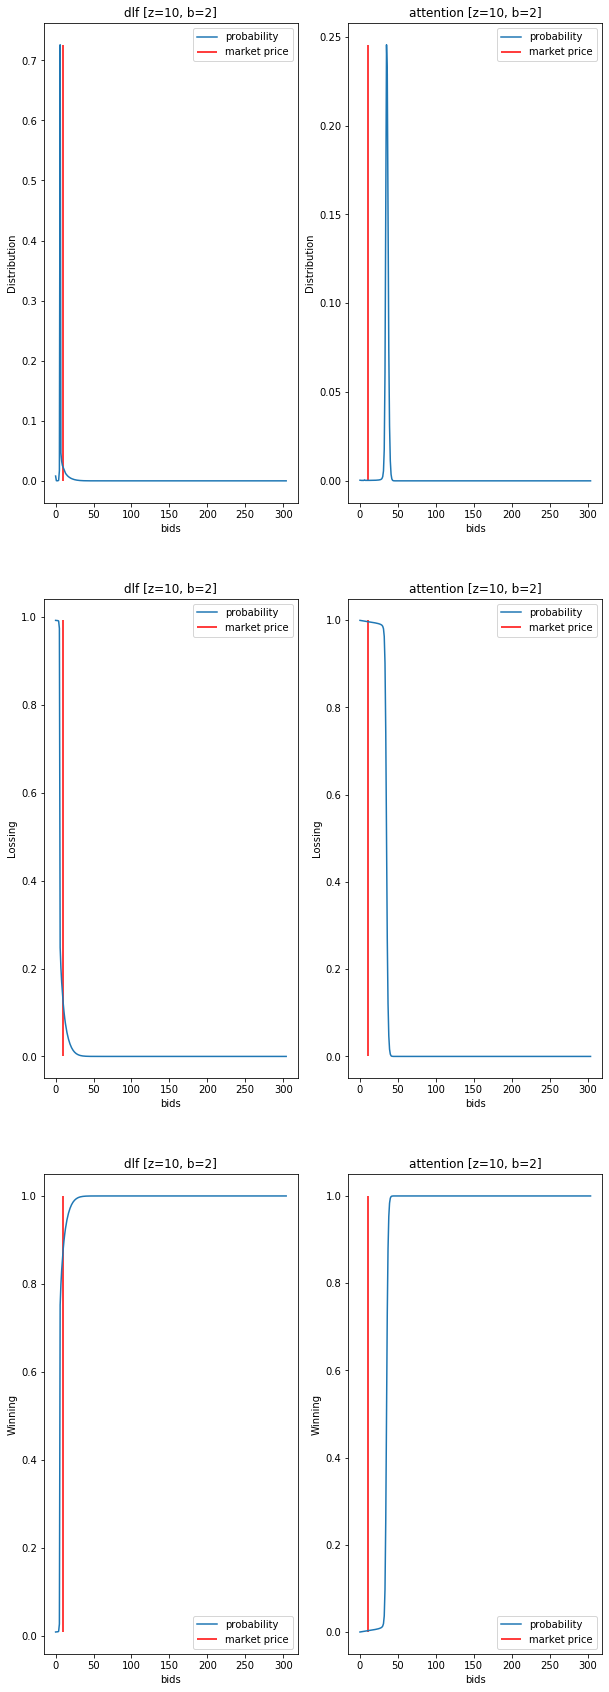

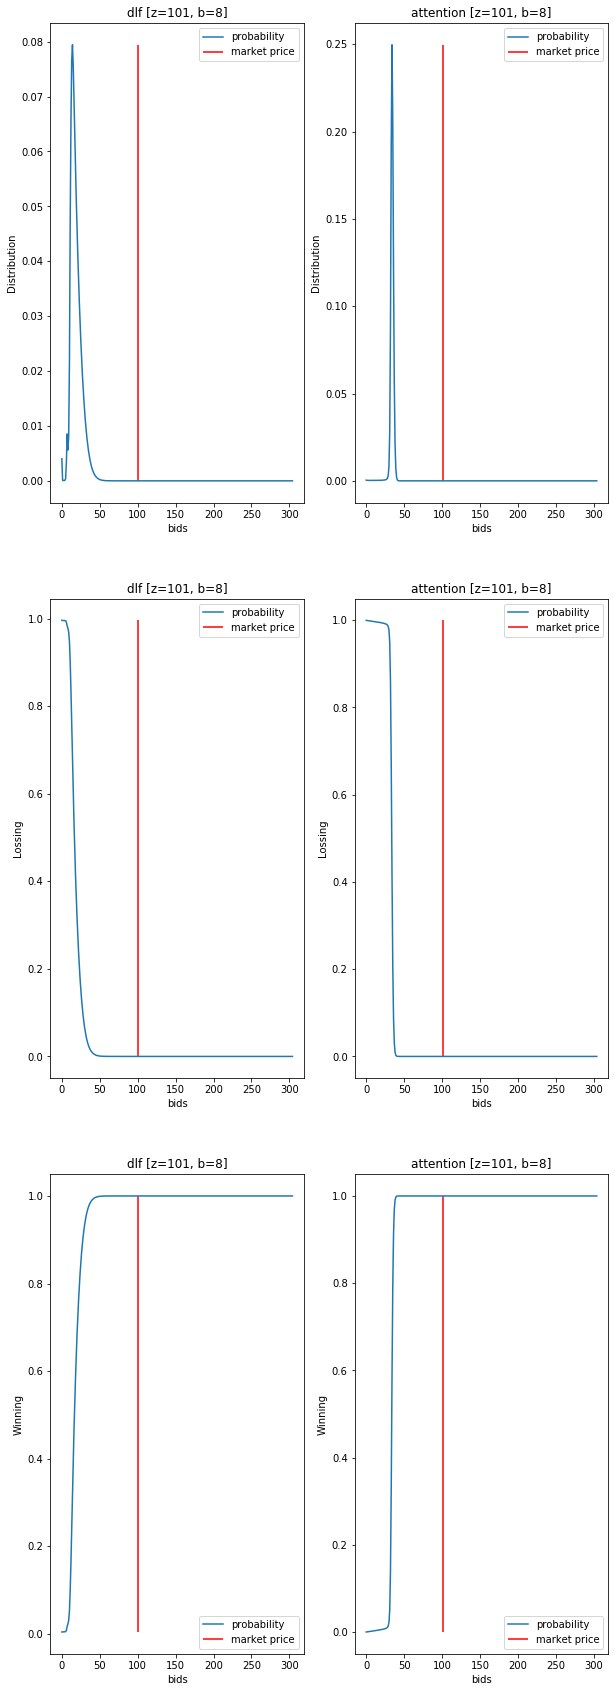

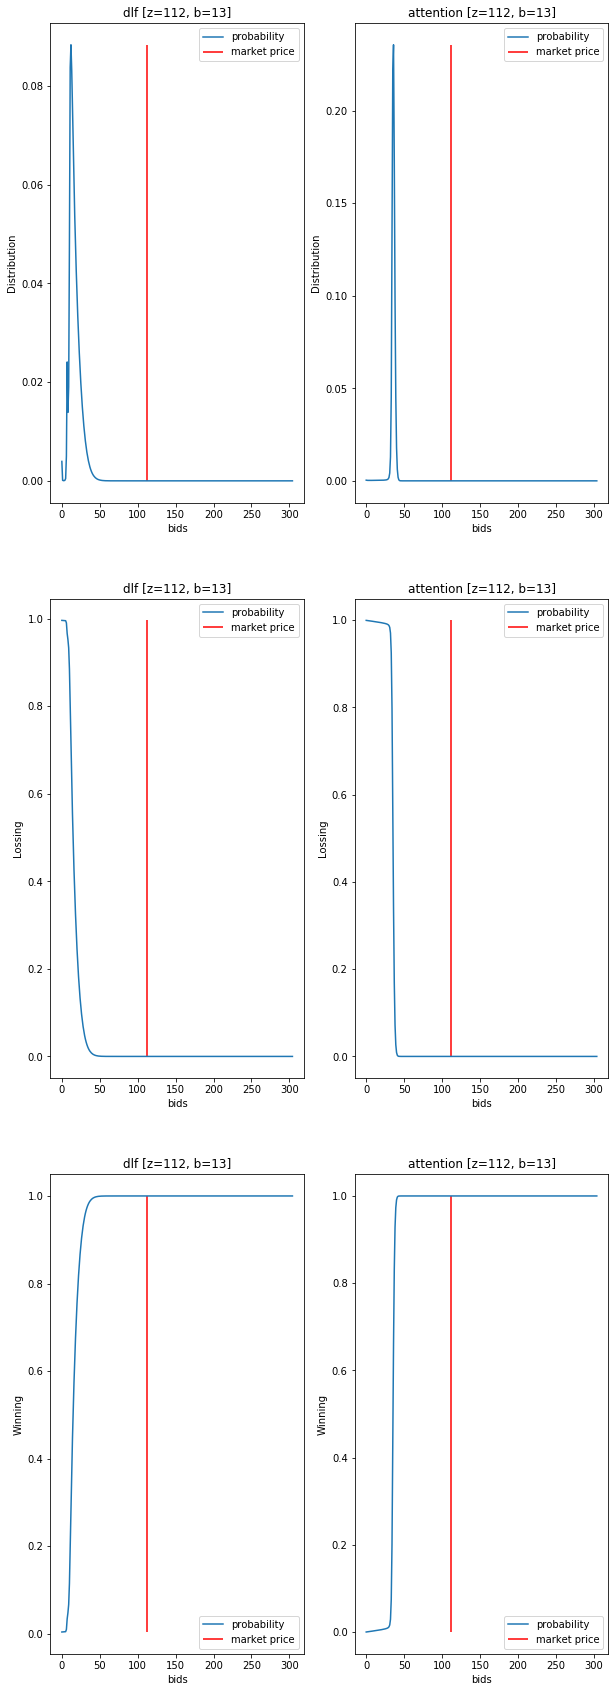

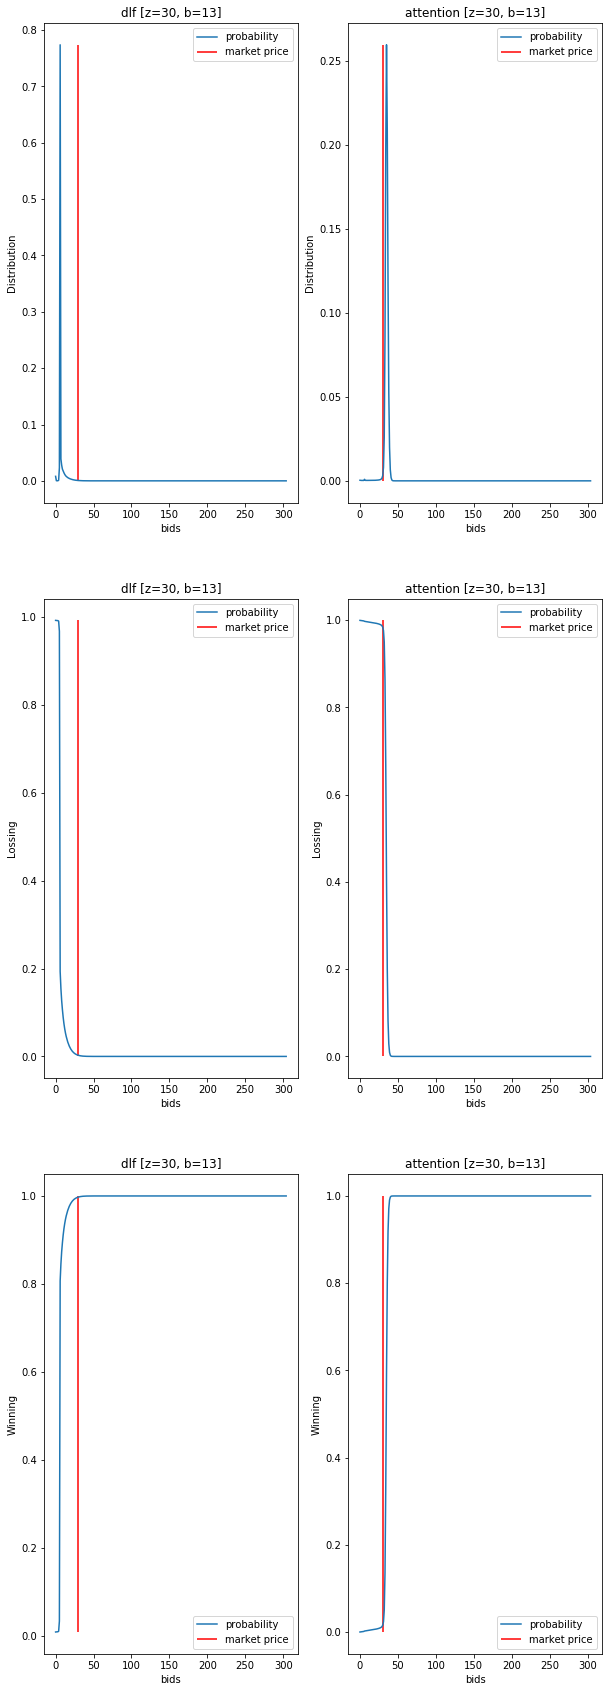

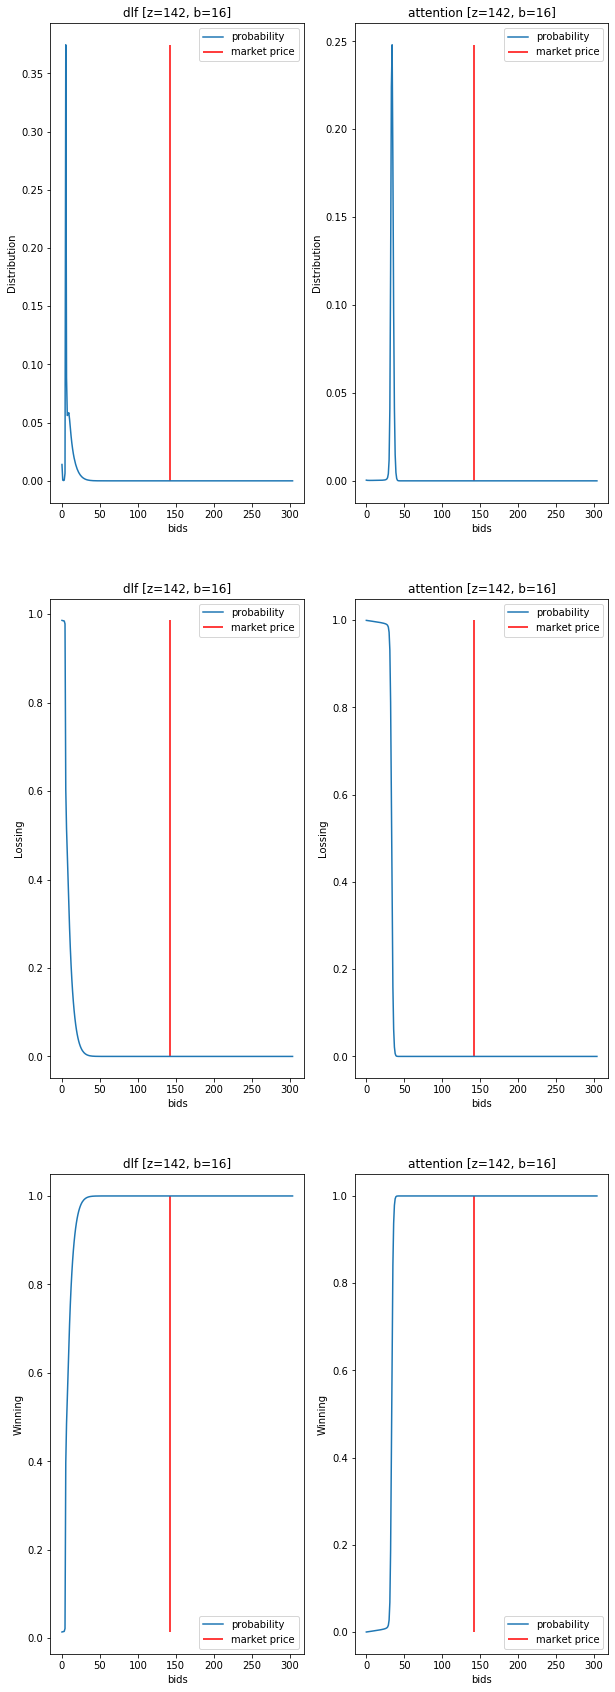

In [10]:
# Lossing cases
features, bids, _ = dataset.next_loss()
predict_and_draw(features, bids)